## Research Replication "Bioinformatics analysis of differentially expressed genes in non alcoholic fatty liver disease using next generation sequencing data"

https://www.biorxiv.org/content/10.1101/2021.12.16.472893v1

data can be downloaded at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135251

In [1]:
import gzip
from glob import glob
import tqdm
import re

import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import requests

%matplotlib inline

In [2]:
samples = sorted(glob('GSE135251/*.txt.gz'))
samples

['GSE135251/GSM3998167_017-Ann-Daly_S1.counts.txt.gz',
 'GSE135251/GSM3998168_018-Ann-Daly_S2.counts.txt.gz',
 'GSE135251/GSM3998169_029-Ann-Daly_S4.counts.txt.gz',
 'GSE135251/GSM3998170_030-Ann-Daly_S5.counts.txt.gz',
 'GSE135251/GSM3998171_031-Ann-Daly_S6.counts.txt.gz',
 'GSE135251/GSM3998172_032-Ann-Daly_S7.counts.txt.gz',
 'GSE135251/GSM3998173_033-Ann-Daly_S8.counts.txt.gz',
 'GSE135251/GSM3998174_035-Ann-Daly_S10.counts.txt.gz',
 'GSE135251/GSM3998175_036-Ann-Daly_S11.counts.txt.gz',
 'GSE135251/GSM3998176_037-Ann-Daly_S12.counts.txt.gz',
 'GSE135251/GSM3998177_038-Ann-Daly_S13.counts.txt.gz',
 'GSE135251/GSM3998178_040-Ann-Daly_S14.counts.txt.gz',
 'GSE135251/GSM3998179_041-Ann-Daly_S15.counts.txt.gz',
 'GSE135251/GSM3998180_042-Ann-Daly_S16.counts.txt.gz',
 'GSE135251/GSM3998181_043-Ann-Daly_S1.counts.txt.gz',
 'GSE135251/GSM3998182_044-Ann-Daly_S2.counts.txt.gz',
 'GSE135251/GSM3998183_046-Ann-Daly_S3.counts.txt.gz',
 'GSE135251/GSM3998184_047-Ann-Daly_S4.counts.txt.gz',
 'G

In [3]:
id_pattern = re.compile(r'GSM\d{7}')

def read_entry(gz):
    with gzip.open(gz, 'rb') as f:
        content = f.read().decode('utf-8')
        lines = [l for l in content.split('\n') if l.startswith('ENSG')]
        entry = {l.split('\t')[0]: l.split('\t')[1] for l in lines}
    id = id_pattern.search(gz).group(0)
    return entry, id


def to_df(samples):
    df = pd.DataFrame()
    raw = {}
    columns = ['gene_id']
    for p in tqdm.tqdm(samples):
        entry, id = read_entry(p)
        columns.append(id)
        for gene, exp in entry.items():
            if gene in raw:
                raw[gene][id] = int(exp)
            else:
                raw[gene] = {id: int(exp)}
    data = []
    for gene, values in raw.items():
        values['gene_id'] = gene
        data.append(values)
    
    df = pd.DataFrame(data=data, columns=columns)
    return df


# read_entry('GSE135251/GSM3998345_C102-Ann-Daly_S3.counts.txt.gz')
# data = read_all(samples)
df = to_df(samples)

100%|██████████| 216/216 [00:10<00:00, 21.43it/s]


In [4]:
df.head()

,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
0,ENSG00000000003,2565,2400,2391,2835,3099,2214,2904,1823,1627,...,2251,1401,2168,2096,2981,2269,2526,2010,1725,1660
1,ENSG00000000005,0,14,0,0,0,7,1,3,3,...,0,0,0,0,1,1,4,11,12,0
2,ENSG00000000419,605,525,709,671,869,500,675,440,316,...,474,364,507,525,713,366,607,572,336,353
3,ENSG00000000457,315,330,329,418,348,347,337,209,276,...,324,260,354,335,410,250,417,310,291,320
4,ENSG00000000460,92,89,115,97,108,65,102,91,48,...,67,126,76,81,89,120,122,84,67,49


In [5]:
df

,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
0,ENSG00000000003,2565,2400,2391,2835,3099,2214,2904,1823,1627,...,2251,1401,2168,2096,2981,2269,2526,2010,1725,1660
1,ENSG00000000005,0,14,0,0,0,7,1,3,3,...,0,0,0,0,1,1,4,11,12,0
2,ENSG00000000419,605,525,709,671,869,500,675,440,316,...,474,364,507,525,713,366,607,572,336,353
3,ENSG00000000457,315,330,329,418,348,347,337,209,276,...,324,260,354,335,410,250,417,310,291,320
4,ENSG00000000460,92,89,115,97,108,65,102,91,48,...,67,126,76,81,89,120,122,84,67,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64248,ENSG00000280450,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64249,ENSG00000280451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64250,ENSG00000280452,0,1,0,0,0,0,0,0,0,...,4,0,1,0,0,0,0,0,0,2
64251,ENSG00000280453,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [6]:
df.columns

Index(['gene_id', 'GSM3998167', 'GSM3998168', 'GSM3998169', 'GSM3998170',
       'GSM3998171', 'GSM3998172', 'GSM3998173', 'GSM3998174', 'GSM3998175',
       ...
       'GSM3998373', 'GSM3998374', 'GSM3998375', 'GSM3998376', 'GSM3998377',
       'GSM3998378', 'GSM3998379', 'GSM3998380', 'GSM3998381', 'GSM3998382'],
      dtype='object', length=217)

In [7]:
df.describe()

,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,GSM3998176,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
count,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,...,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04,6.425300e+04
mean,3.624450e+02,3.104101e+02,3.816963e+02,4.365038e+02,4.424738e+02,3.880400e+02,3.852430e+02,3.823852e+02,2.917641e+02,3.743863e+02,...,3.328074e+02,2.572119e+02,3.250690e+02,2.871819e+02,3.777033e+02,3.201073e+02,4.026245e+02,3.286351e+02,3.309949e+02,3.251886e+02
std,1.519091e+04,1.317396e+04,1.580488e+04,1.994366e+04,1.819763e+04,2.129181e+04,1.541409e+04,1.701143e+04,1.435943e+04,1.617331e+04,...,1.219118e+04,5.774114e+03,1.130217e+04,9.584957e+03,1.497407e+04,1.018385e+04,1.657013e+04,1.417851e+04,1.201865e+04,8.796796e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00,4.000000e+00,5.000000e+00,...,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,8.000000e+00,8.000000e+00,1.100000e+01
max,3.547755e+06,3.091362e+06,3.667287e+06,4.749437e+06,4.177039e+06,5.195662e+06,3.478443e+06,3.861182e+06,3.467423e+06,3.845354e+06,...,2.817134e+06,1.044250e+06,2.585355e+06,2.188885e+06,3.543593e+06,2.227487e+06,3.897741e+06,3.415521e+06,2.745419e+06,1.857594e+06


In [8]:
df.isnull().describe()

,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
count,64253,64253,64253,64253,64253,64253,64253,64253,64253,64253,...,64253,64253,64253,64253,64253,64253,64253,64253,64253,64253
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,64253,64253,64253,64253,64253,64253,64253,64253,64253,64253,...,64253,64253,64253,64253,64253,64253,64253,64253,64253,64253


In [9]:
CONTROL_SAMPLES = ['GSM3998341', 'GSM3998342', 'GSM3998216', 'GSM3998217', 'GSM3998218',
                   'GSM3998220', 'GSM3998221', 'GSM3998222', 'GSM3998223', 'GSM3998224']

for c in CONTROL_SAMPLES:
    assert c in df.columns

In [10]:
def normalize(df):
    normed = df.copy()
    for column in normed.columns:
        if column != 'gene_id':
            normed[column] = np.where(normed[column] == 0, 0, np.log(normed[column]))
    return normed


norm_df = normalize(df)
norm_df.head()

/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: d

/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: d

/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kiddos/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: d

,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
0,ENSG00000000003,7.849714,7.783224,7.779467,7.949797,8.038835,7.702556,7.973844,7.508239,7.394493,...,7.719130,7.244942,7.681560,7.647786,8.000014,7.727094,7.834392,7.605890,7.452982,7.414573
1,ENSG00000000005,0.000000,2.639057,0.000000,0.000000,0.000000,1.945910,0.000000,1.098612,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,2.397895,2.484907,0.000000
2,ENSG00000000419,6.405228,6.263398,6.563856,6.508769,6.767343,6.214608,6.514713,6.086775,5.755742,...,6.161207,5.897154,6.228511,6.263398,6.569481,5.902633,6.408529,6.349139,5.817111,5.866468
3,ENSG00000000457,5.752573,5.799093,5.796058,6.035481,5.852202,5.849325,5.820083,5.342334,5.620401,...,5.780744,5.560682,5.869297,5.814131,6.016157,5.521461,6.033086,5.736572,5.673323,5.768321
4,ENSG00000000460,4.521789,4.488636,4.744932,4.574711,4.682131,4.174387,4.624973,4.510860,3.871201,...,4.204693,4.836282,4.330733,4.394449,4.488636,4.787492,4.804021,4.430817,4.204693,3.891820


In [11]:
norm_df.describe()

,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,GSM3998176,...,GSM3998373,GSM3998374,GSM3998375,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382
count,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,...,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000
mean,1.337833,1.331462,1.366058,1.403664,1.397837,1.320610,1.385012,1.317170,1.220546,1.294554,...,1.368969,1.346868,1.375325,1.374323,1.409899,1.413069,1.438126,1.376507,1.366646,1.461495
std,2.352238,2.321134,2.393136,2.431364,2.431696,2.351987,2.403244,2.342903,2.248556,2.354476,...,2.372721,2.329113,2.372352,2.359500,2.420061,2.397839,2.437816,2.374459,2.350262,2.438565
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.791759,1.945910,1.945910,2.079442,2.079442,1.791759,2.079442,1.791759,1.386294,1.609438,...,2.079442,2.079442,2.079442,2.079442,2.197225,2.302585,2.302585,2.079442,2.079442,2.397895
max,15.081826,14.944122,15.114963,15.373537,15.245113,15.463335,15.062095,15.166484,15.058922,15.162376,...,14.851231,13.858809,14.765373,14.598903,15.080652,14.616385,15.175908,15.043841,14.825444,14.434793


In [12]:
experiment = [c for c in CONTROL_SAMPLES]
def compute_p_value(df):
    analysis_df = df.copy()
    statistics = []
    p_values = []
    logfc = []
    for i in tqdm.tqdm(range(len(analysis_df))):
        x = analysis_df.iloc[i]
        a = []
        b = []
        
        for index, value in x.items():
            if index == 'gene_id':
                continue
            if index in CONTROL_SAMPLES:
                b.append(value)
            else:
                a.append(value)
        a = np.array(a)
        b = np.array(b)
        result = stats.ttest_ind(a, b)
        statistics.append(result.statistic)
        p_values.append(result.pvalue)
        logfc.append(np.mean(a) - np.mean(b))
    analysis_df = analysis_df.assign(p_val=np.array(p_values))
    analysis_df = analysis_df.assign(stats=np.array(statistics))
    analysis_df = analysis_df.assign(logfc=np.array(logfc))
    return analysis_df


analysis_df = compute_p_value(norm_df)
analysis_df.head()

100%|██████████| 64253/64253 [00:28<00:00, 2289.43it/s]


,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382,p_val,stats,logfc
0,ENSG00000000003,7.849714,7.783224,7.779467,7.949797,8.038835,7.702556,7.973844,7.508239,7.394493,...,7.647786,8.000014,7.727094,7.834392,7.605890,7.452982,7.414573,0.850607,0.188571,0.021725
1,ENSG00000000005,0.000000,2.639057,0.000000,0.000000,0.000000,1.945910,0.000000,1.098612,1.098612,...,0.000000,0.000000,0.000000,1.386294,2.397895,2.484907,0.000000,0.249341,-1.155093,-0.361834
2,ENSG00000000419,6.405228,6.263398,6.563856,6.508769,6.767343,6.214608,6.514713,6.086775,5.755742,...,6.263398,6.569481,5.902633,6.408529,6.349139,5.817111,5.866468,0.095972,1.672070,0.212262
3,ENSG00000000457,5.752573,5.799093,5.796058,6.035481,5.852202,5.849325,5.820083,5.342334,5.620401,...,5.814131,6.016157,5.521461,6.033086,5.736572,5.673323,5.768321,0.049744,1.973339,0.166940
4,ENSG00000000460,4.521789,4.488636,4.744932,4.574711,4.682131,4.174387,4.624973,4.510860,3.871201,...,4.394449,4.488636,4.787492,4.804021,4.430817,4.204693,3.891820,0.519650,-0.644950,-0.089923


the paper said it used <b>Benjamini and Hochberg</b> method to adjust p-value

I just compute the regular t test p-value here

In [13]:
analysis_df.describe()

,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,GSM3998176,...,GSM3998376,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382,p_val,stats,logfc
count,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,...,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,64253.000000,3.501200e+04,35012.000000,64253.000000
mean,1.337833,1.331462,1.366058,1.403664,1.397837,1.320610,1.385012,1.317170,1.220546,1.294554,...,1.374323,1.409899,1.413069,1.438126,1.376507,1.366646,1.461495,3.560008e-01,0.590009,0.040876
std,2.352238,2.321134,2.393136,2.431364,2.431696,2.351987,2.403244,2.342903,2.248556,2.354476,...,2.359500,2.420061,2.397839,2.437816,2.374459,2.350262,2.438565,3.320118e-01,2.549551,0.282941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.447286e-31,-13.849524,-4.113740
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250783e-02,-0.658199,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.773833e-01,0.315901,0.000000
75%,1.791759,1.945910,1.945910,2.079442,2.079442,1.791759,2.079442,1.791759,1.386294,1.609438,...,2.079442,2.197225,2.302585,2.302585,2.079442,2.079442,2.397895,6.937923e-01,1.485653,0.027385
max,15.081826,14.944122,15.114963,15.373537,15.245113,15.463335,15.062095,15.166484,15.058922,15.162376,...,14.598903,15.080652,14.616385,15.175908,15.043841,14.825444,14.434793,9.998969e-01,13.737573,3.513959


### Volcano chart

In [14]:
def get_gene_name(ensemble_id):
    """
    I found this webservice with this API to convert ensemble id to actual gene name
    post the url with the following form data:
    
    keep_ids: on (optional)
    input_data: <ensemble_id>
    """
    url = 'https://www.biotools.fr/mouse/ensembl_symbol_converter/?presenter=none'
    form_data = {'input_data': ensemble_id}
    resp = requests.post(url, form_data)
    return resp.text.strip()


get_gene_name('ENSG00000000003')

'TSPAN6'

100%|██████████| 64253/64253 [01:15<00:00, 850.89it/s] 


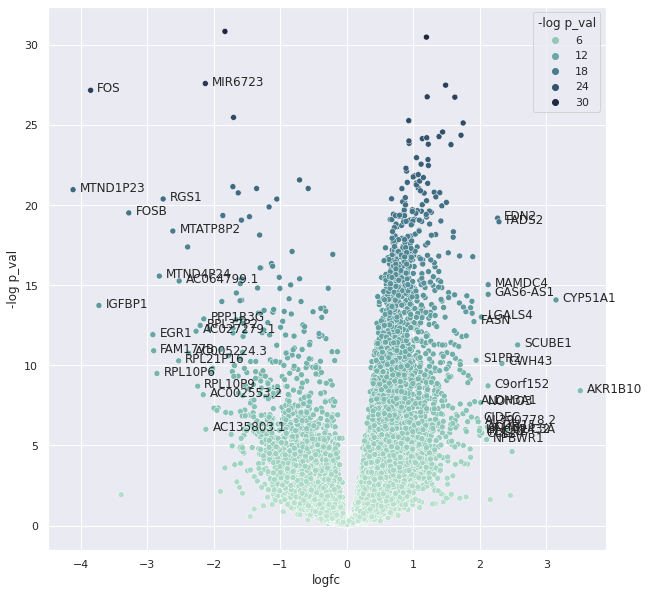

In [15]:
analysis_df['-log p_val'] = -np.log10(analysis_df['p_val'])

sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 10))
sns.scatterplot(x='logfc', y='-log p_val', hue='-log p_val',
                palette='ch:rot=-.33',
                data=analysis_df)

ax = plt.gca()
for r in tqdm.tqdm(range(len(analysis_df))):
    x = analysis_df.iloc[r]['logfc'] + 0.1
    y = analysis_df.iloc[r]['-log p_val'] - 0.1
    if y >= 5 and np.abs(x) >= 2:
        ensemble_id = analysis_df.iloc[r]['gene_id']
        text = get_gene_name(ensemble_id)
        ax.text(x, y, text, horizontalalignment='left')

plt.show()

In [16]:
def transpose_df(df):
    T = df.T
    columns = ['patient_id'] + [id for id in T.values[0, :]]
    data = []
    n = len(columns)
    values = T.values
    index = T.index
    for i in tqdm.tqdm(range(1, len(T))):
        entry = {values[0, j] : values[i, j] for j in range(0, n-1)}
        entry['patient_id'] = index[i]
        data.append(entry)
    transposed = pd.DataFrame(columns=columns, data=data)
    return transposed


transposed_df = transpose_df(norm_df)
transposed_df.head()

100%|██████████| 216/216 [00:03<00:00, 54.11it/s]


,patient_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000280445,ENSG00000280446,ENSG00000280447,ENSG00000280448,ENSG00000280449,ENSG00000280450,ENSG00000280451,ENSG00000280452,ENSG00000280453,ENSG00000280454
0,GSM3998167,7.849714,0.000000,6.405228,5.752573,4.521789,4.564348,10.642993,6.716595,8.123558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GSM3998168,7.783224,2.639057,6.263398,5.799093,4.488636,4.510860,10.563414,6.815640,7.707063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GSM3998169,7.779467,0.000000,6.563856,5.796058,4.744932,5.676754,10.538582,6.981006,8.059276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GSM3998170,7.949797,0.000000,6.508769,6.035481,4.574711,4.744932,10.664200,7.054450,7.784057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GSM3998171,8.038835,0.000000,6.767343,5.852202,4.682131,4.969813,10.712928,6.783325,8.080237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def select_gene(analysis_df, log_p_value_threshold=5.0, fc_threshold=2.0):
    ids = []
    for i in range(len(analysis_df)):
        logfc = analysis_df.iloc[i]['logfc']
        p_val = analysis_df.iloc[i]['-log p_val']
        if p_val >= log_p_value_threshold and np.abs(logfc) >= fc_threshold:
            ids.append(analysis_df.iloc[i]['gene_id'])
    return ids


selected_genes = select_gene(analysis_df)
A = transposed_df.copy()[selected_genes]
A = A.set_index(transposed_df['patient_id'])
A.head()

,ENSG00000001630,ENSG00000087085,ENSG00000090104,ENSG00000103226,ENSG00000106178,ENSG00000109182,ENSG00000120738,ENSG00000125740,ENSG00000127129,ENSG00000129910,...,ENSG00000233695,ENSG00000233913,ENSG00000239559,ENSG00000244245,ENSG00000260816,ENSG00000266378,ENSG00000272864,ENSG00000275413,ENSG00000276967,ENSG00000278791
patient_id,,,,,,,,,,,,,,,,,,,,,
GSM3998167,2.397895,3.295837,1.945910,3.332205,2.302585,3.784190,7.801391,1.609438,2.944439,4.700480,...,4.543295,2.833213,2.833213,1.386294,1.791759,1.945910,3.367296,1.791759,1.098612,0.0
GSM3998168,4.672829,1.098612,2.639057,3.367296,2.197225,3.465736,5.552960,1.609438,2.833213,3.091042,...,4.488636,2.302585,2.708050,0.000000,0.000000,0.000000,2.995732,1.791759,0.000000,0.0
GSM3998169,2.484907,3.091042,4.828314,3.295837,1.386294,0.000000,7.200425,4.077537,2.197225,0.693147,...,4.094345,3.091042,3.401197,0.693147,1.609438,1.609438,4.304065,3.178054,2.197225,0.0
GSM3998170,3.891820,4.343805,2.890372,3.806662,1.791759,3.912023,5.713733,0.000000,2.197225,1.945910,...,4.543295,3.258097,3.806662,1.945910,1.386294,1.386294,3.761200,2.772589,2.708050,0.0
GSM3998171,4.718499,3.332205,2.944439,3.258097,0.693147,3.218876,5.327876,2.197225,3.526361,3.555348,...,4.718499,2.833213,3.135494,1.609438,0.000000,0.000000,3.912023,2.484907,2.197225,0.0


<Figure size 720x720 with 0 Axes>

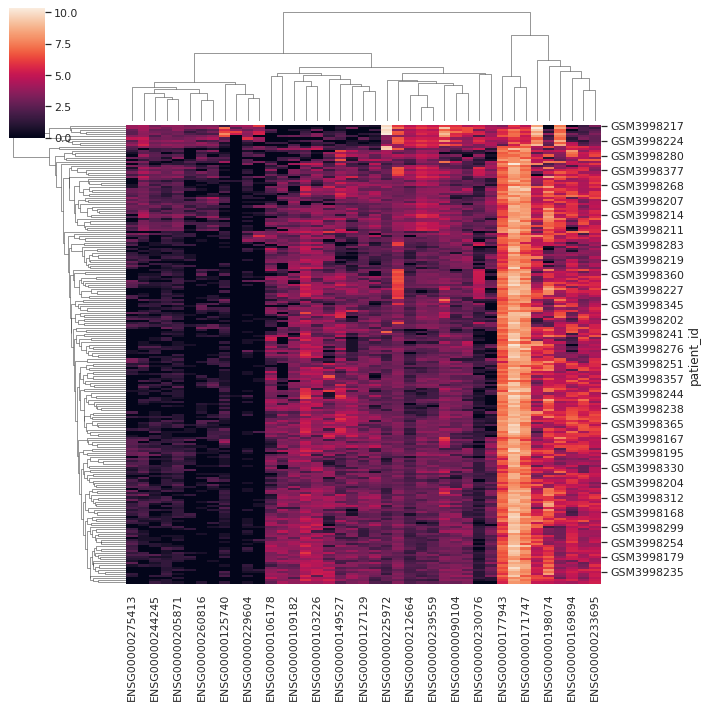

In [18]:
plt.figure(figsize=(10, 10))
sns.clustermap(A)
plt.show()

### Gene Data visualization

In [19]:
X = analysis_df.values[:, 1:-4].astype(np.float64)
print(X.shape)

(64253, 216)


#### PCA

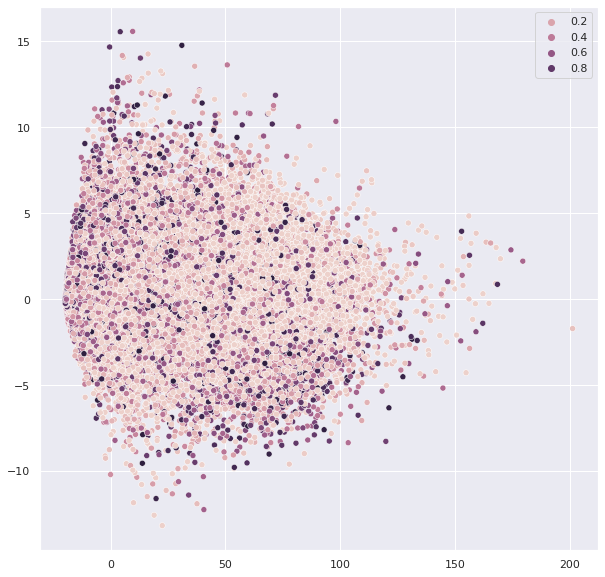

In [20]:
pca = PCA(n_components=2)
pca.fit(X)
T = pca.transform(X)

p_value = analysis_df['p_val'].values

plt.figure(figsize=(10, 10))
sns.scatterplot(x=T[:, 0], y=T[:, 1], hue=p_value)
plt.show()

#### TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.578003
[t-SNE] KL divergence after 1000 iterations: 1.627086
(2000, 2)


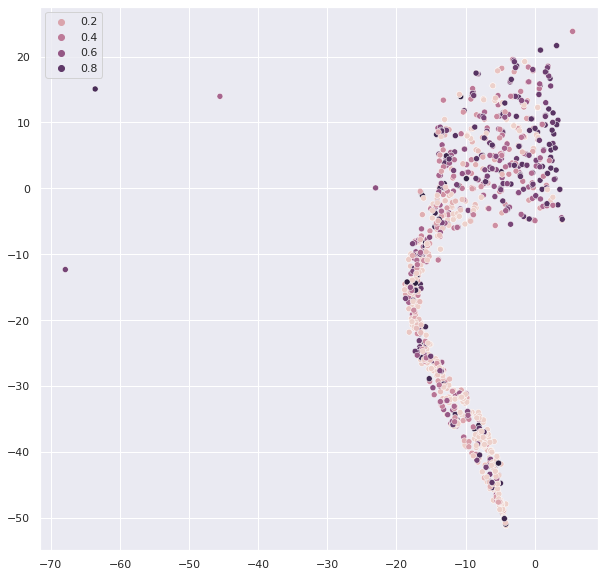

In [21]:
selected_index = np.random.choice(len(X), 2000)
selected_X = X[selected_index]

T = TSNE(n_components=2, init='random', verbose=1).fit_transform(selected_X)

print(T.shape)

p_value = analysis_df['p_val'].values[selected_index]
plt.figure(figsize=(10, 10))
sns.scatterplot(x=T[:, 0], y=T[:, 1], hue=p_value)
plt.show()

#### Auto Encoder

In [22]:
INPUT_SIZE = 216
LATENT_SIZE = 64


def create_auto_encoder():
    sizes = [512, 512, 256, 256]
    inputs = keras.Input(shape=[INPUT_SIZE])
    x = inputs
    for s in sizes:
        x = keras.layers.Dense(s, activation='tanh')(x)
    latent = keras.layers.Dense(LATENT_SIZE, name='latent', activation='tanh')(x)
    x = latent
    for s in sizes[::-1]:
        x = keras.layers.Dense(s, activation='tanh')(x)
    x = keras.layers.Dense(INPUT_SIZE)(x)
    return keras.Model(inputs=[inputs], outputs=[latent, x])


keras.backend.clear_session()
model = create_auto_encoder()
model.summary()

optimizer = keras.optimizers.Adam(1e-4)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 216)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               111104    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
latent (Dense)               (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640 

In [23]:
BATCH_SIZE = 256
EPOCHS = 60


@tf.function(jit_compile=True)
def train_step(inputs):
    with tf.GradientTape() as tape:
        latent, outputs = model(inputs)
        loss = tf.reduce_sum(tf.square(outputs-inputs)) / tf.cast(tf.shape(inputs)[0], tf.float32)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


def train():
    ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
    ds = ds.shuffle(10000).batch(BATCH_SIZE)
    for epoch in range(EPOCHS):
        losses = []
        for batch in ds:
            loss = train_step(batch)
            losses.append(loss.numpy())
        print('loss: ', np.mean(losses))


train()

loss:  693.82495
loss:  73.056404
loss:  49.8426
loss:  34.512466
loss:  31.149162
loss:  32.09849
loss:  26.921661
loss:  26.024822
loss:  27.871094
loss:  23.788929
loss:  23.477465
loss:  24.870096
loss:  21.598392
loss:  22.155087
loss:  21.193722
loss:  23.582067
loss:  20.321022
loss:  20.111794
loss:  24.210892
loss:  19.625324
loss:  19.445017
loss:  21.615826
loss:  18.959396
loss:  19.603355
loss:  18.83006
loss:  23.007748
loss:  18.34823
loss:  18.067429
loss:  20.444944
loss:  17.849314
loss:  18.166807
loss:  19.401138
loss:  17.352661
loss:  17.85585
loss:  20.0758
loss:  16.993666
loss:  17.088156
loss:  18.506035
loss:  16.552677
loss:  20.35697
loss:  16.41371
loss:  16.351307
loss:  18.975454
loss:  16.076143
loss:  15.999621
loss:  17.65372
loss:  15.72414
loss:  17.767315
loss:  15.582493
loss:  16.376307
loss:  15.76149
loss:  16.979519
loss:  15.156525
loss:  17.144304
loss:  15.028873
loss:  14.968517
loss:  20.196012
loss:  14.858305
loss:  14.84911
loss:  14.7

100%|██████████| 251/251 [00:06<00:00, 38.40it/s]


(64253, 64)


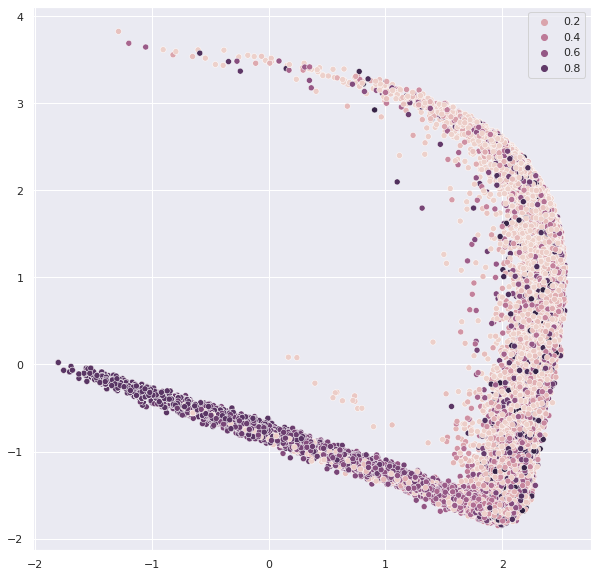

In [24]:
def compute_latent():
    ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
    ds = ds.batch(BATCH_SIZE)
    latent = []
    for batch in tqdm.tqdm(ds):
        l, _ = model.predict(batch)
        latent.append(l)
    return np.concatenate(latent, axis=0)


latent = compute_latent()
print(latent.shape)

pca = PCA(n_components=LATENT_SIZE)
pca.fit(latent)
T = pca.transform(latent)

p_value = analysis_df['p_val'].values
plt.figure(figsize=(10, 10))
sns.scatterplot(x=T[:, 0], y=T[:, 1], hue=p_value)
plt.show()

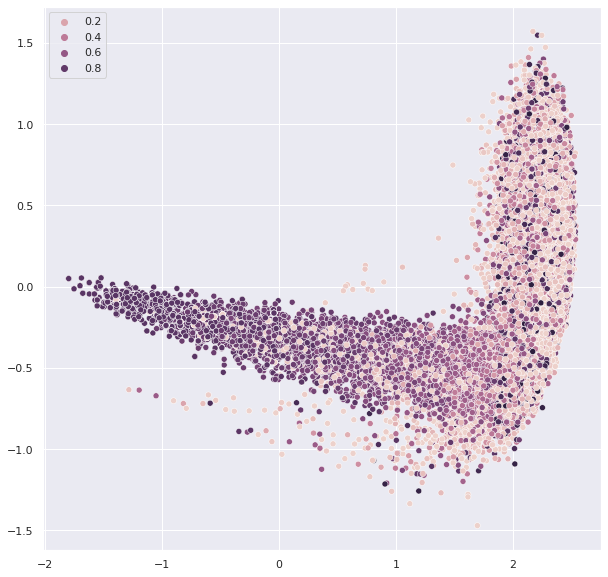

In [25]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=T[:, 0], y=T[:, 2], hue=p_value)
plt.show()

### Patient Data visualization

I am expecteding that the data would be group in two 2 components, since we have experimental group and control group.

In [26]:
transposed_df.head()

,patient_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000280445,ENSG00000280446,ENSG00000280447,ENSG00000280448,ENSG00000280449,ENSG00000280450,ENSG00000280451,ENSG00000280452,ENSG00000280453,ENSG00000280454
0,GSM3998167,7.849714,0.000000,6.405228,5.752573,4.521789,4.564348,10.642993,6.716595,8.123558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GSM3998168,7.783224,2.639057,6.263398,5.799093,4.488636,4.510860,10.563414,6.815640,7.707063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GSM3998169,7.779467,0.000000,6.563856,5.796058,4.744932,5.676754,10.538582,6.981006,8.059276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GSM3998170,7.949797,0.000000,6.508769,6.035481,4.574711,4.744932,10.664200,7.054450,7.784057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GSM3998171,8.038835,0.000000,6.767343,5.852202,4.682131,4.969813,10.712928,6.783325,8.080237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.005s...
[t-SNE] Computed neighbors for 216 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 26.724624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.588867
[t-SNE] KL divergence after 1000 iterations: 0.724506


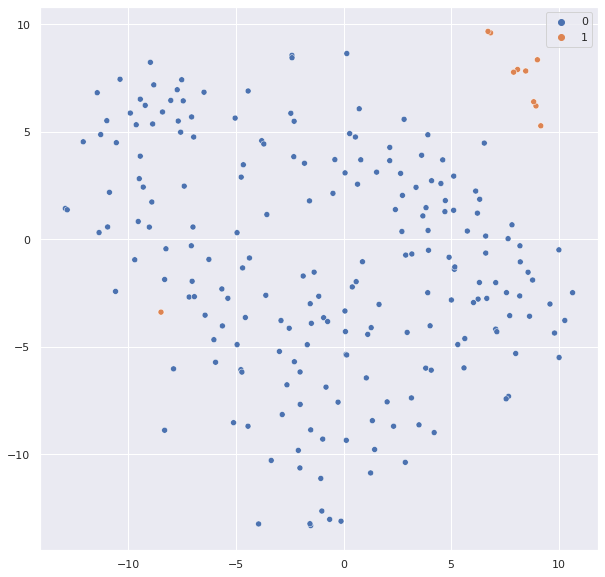

In [27]:
X = transposed_df[transposed_df.columns[1:]].values

T = TSNE(n_components=2, init='random', verbose=1).fit_transform(X)

control = [int(r[0] in CONTROL_SAMPLES) for r in transposed_df.values ]
plt.figure(figsize=(10, 10))
sns.scatterplot(x=T[:, 0], y=T[:, 1], hue=control)
plt.show()

It turns out experimental samples are grouped in the middle and control samples separated into 2 groups using TSNE visualization

### Receiver operating characteristic curve (ROC) analysis

the paper select 10 genes to separate normal samples and NAFLD samples:
- ESR2   (ENSG00000140009)
- JUN    (ENSG00000177606)
- PTN    (ENSG00000105894)
- PTGER3 (ENSG00000050628)
- CEBPB  (ENSG00000172216)
- IKBKG  (ENSG00000269335)
- HSPA8  (ENSG00000109971)
- SFN    (ENSG00000175793)
- CDKN1A (ENSG00000124762)
- E2F1   (ENSG00000101412)

In [28]:
TARGET_GENE = ['ENSG00000140009', 'ENSG00000177606', 'ENSG00000105894', 'ENSG00000050628', 'ENSG00000172216',
               'ENSG00000269335', 'ENSG00000109971', 'ENSG00000175793', 'ENSG00000124762', 'ENSG00000101412']

for gene in TARGET_GENE:
    assert gene in transposed_df.columns

In [29]:
def select_gene_df(analysis_df):
    indices = []
    for i in range(len(analysis_df)):
        if analysis_df.iloc[i]['gene_id'] in TARGET_GENE:
            indices.append(analysis_df.index[i])
    return analysis_df.copy().iloc[indices]


target_df = select_gene_df(analysis_df)
target_df

,gene_id,GSM3998167,GSM3998168,GSM3998169,GSM3998170,GSM3998171,GSM3998172,GSM3998173,GSM3998174,GSM3998175,...,GSM3998377,GSM3998378,GSM3998379,GSM3998380,GSM3998381,GSM3998382,p_val,stats,logfc,-log p_val
682,ENSG00000050628,0.000000,2.079442,1.609438,1.791759,1.098612,0.000000,1.098612,0.000000,0.693147,...,1.098612,2.397895,0.000000,1.386294,1.386294,2.079442,3.687675e-05,-4.214756,-1.146256,4.433247
2524,ENSG00000101412,2.079442,2.833213,4.007333,3.871201,3.806662,3.583519,3.737670,3.806662,2.302585,...,2.772589,3.367296,4.077537,3.258097,3.951244,4.025352,2.041127e-05,4.357565,1.100325,4.690130
3220,ENSG00000105894,3.761200,3.970292,4.025352,3.871201,3.610918,3.891820,4.204693,3.583519,4.043051,...,4.077537,4.369448,3.806662,3.610918,3.871201,4.465908,1.712973e-08,-5.862092,-0.889303,7.766250
3729,ENSG00000109971,9.720406,9.556621,9.743201,9.975855,10.147884,9.894699,9.743436,9.808462,9.095603,...,9.878170,9.708992,10.204740,9.419142,9.358847,9.694986,6.773146e-21,10.442637,1.500217,20.169210
5586,ENSG00000124762,7.102499,6.965080,7.092574,7.044905,7.161622,7.420579,7.350516,6.656727,5.872118,...,6.517671,7.271009,7.526718,6.965080,6.852243,7.287561,2.881608e-15,8.518686,1.533007,14.540365
7930,ENSG00000140009,0.693147,0.000000,0.000000,0.000000,0.000000,1.098612,0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.098612,1.386294,0.000000,6.407928e-03,-2.753245,-0.521900,2.193282
13285,ENSG00000172216,6.749931,6.006353,6.618739,6.289716,6.892642,5.834811,6.727432,6.658011,6.011267,...,6.490724,6.866933,6.744059,6.597146,6.331502,6.214608,1.769991e-13,-7.867630,-0.960473,12.752029
14002,ENSG00000175793,0.000000,1.609438,0.693147,1.386294,2.833213,0.000000,1.609438,0.000000,0.000000,...,0.000000,2.708050,2.397895,1.098612,1.098612,2.890372,2.073428e-02,2.330065,0.784050,1.683311
14382,ENSG00000177606,6.340359,5.908083,7.289611,6.320768,6.154858,5.075174,6.054439,4.912655,4.060443,...,5.517453,5.662960,6.371612,5.298317,5.564520,6.583409,9.908333e-04,-3.339262,-0.604588,3.003999
54822,ENSG00000269335,4.234107,4.290459,4.219508,4.343805,4.356709,4.077537,4.430817,4.204693,4.094345,...,4.304065,4.634729,4.454347,4.499810,4.060443,5.023881,7.489278e-26,12.046341,1.751855,25.125560


In [30]:
target_df[['gene_id', 'p_val', 'logfc', '-log p_val']]

,gene_id,p_val,logfc,-log p_val
682,ENSG00000050628,3.687675e-05,-1.146256,4.433247
2524,ENSG00000101412,2.041127e-05,1.100325,4.690130
3220,ENSG00000105894,1.712973e-08,-0.889303,7.766250
3729,ENSG00000109971,6.773146e-21,1.500217,20.169210
5586,ENSG00000124762,2.881608e-15,1.533007,14.540365
7930,ENSG00000140009,6.407928e-03,-0.521900,2.193282
13285,ENSG00000172216,1.769991e-13,-0.960473,12.752029
14002,ENSG00000175793,2.073428e-02,0.784050,1.683311
14382,ENSG00000177606,9.908333e-04,-0.604588,3.003999
54822,ENSG00000269335,7.489278e-26,1.751855,25.125560


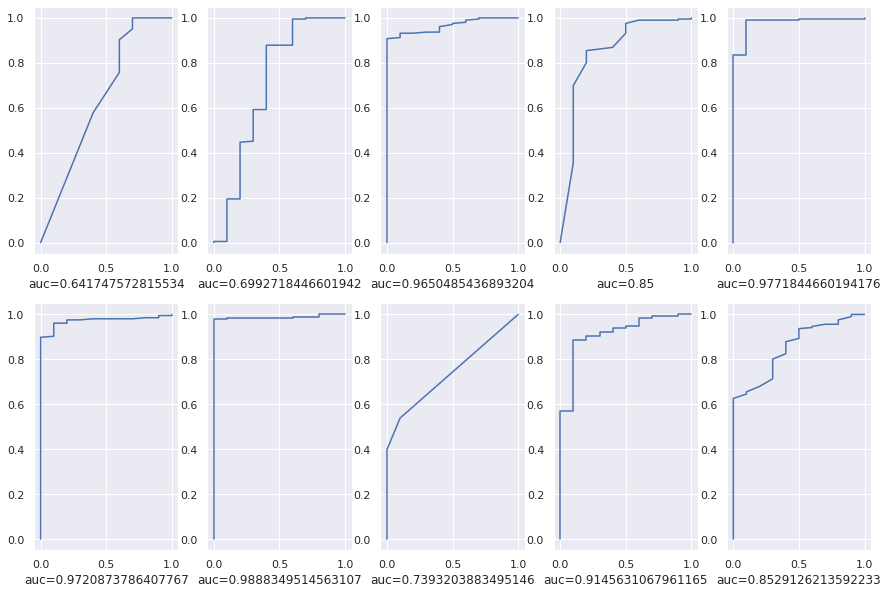

In [31]:
def plot_predictor_roc(df, gene):
    X = np.array(df[gene].array).reshape([-1, 1])
    y = 1. - np.array(df['patient_id'].isin(CONTROL_SAMPLES).array).astype(np.float32)
    model = LogisticRegression().fit(X, y)
    prediction = np.max(model.predict_proba(X), axis=1)
    # print(prediction)
    fpr, tpr, _ = metrics.roc_curve(y, prediction)
    # print(fpr, tpr)
    auc = metrics.roc_auc_score(y, prediction)
    # print(auc)
    plt.plot(fpr, tpr)
    plt.xlabel(f'auc={auc}')


plt.figure(figsize=(15, 10))
for i, gene in enumerate(TARGET_GENE):
    plt.subplot(2, 5, i+1)
    plot_predictor_roc(transposed_df, gene)
plt.show()

I wonder why `ENSG00000140009`, `ENSG00000177606`, `ENSG00000175793` is selected

the expression value seems similar in both experimental group and control group